In [12]:
import numpy as np
import matplotlib.pyplot as plt

### Theorem analysis

In [1]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('augapply-tokenizer')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'right'

In [23]:
files = ['../dataset/augletter.v']
theorems = []

for file in files:
    data = open(file, 'r').read()
    for th in data.split('Theorem')[1:]:
        theorems.append('Theorem' + th)

print('Collected {0} theorems'.format(len(theorems)))
print(theorems[-1])

Collected 5483689 theorems
Theorem ejqhmv: forall (R U Z M P : Prop), (U -> R) -> ((Z -> M) -> R) -> ((U -> Z) -> R -> Z) -> (R -> Z) -> ((P -> Z) -> M) -> Z.
Proof.
intros R U Z M P. intros HUR HZMR HUZRZ HRZ HPZM. apply HRZ. apply HZMR. intros HZ. apply HPZM. intros HP. apply HZ. 
Qed.



In [24]:
# We can count number of tactics in proof by counting total number of dots

def tactic_count(th):
    return th.count('.') - 3

print(theorems[0])
print(f'Tactic number {tactic_count(theorems[0])}')

Theorem fvofjc: forall (U T W : Prop), U -> U.
Proof.
intros U T W. intros HU. apply HU. 
Qed.

Tactic number 3


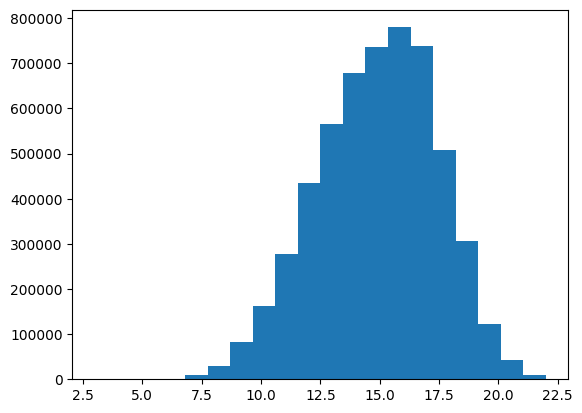

In [25]:
counts = np.array([tactic_count(th) for th in theorems])

plt.hist(counts[counts < 75], bins=20)
plt.show()

In [ ]:
tokens = [tokenizer.encode(th) for th in theorems]

print('Total tokens {0}'.format(sum(len(tok) for tok in tokens)))

In [ ]:
import pickle

pickle.dump(tokens, open('augapply-tokens', 'wb'))

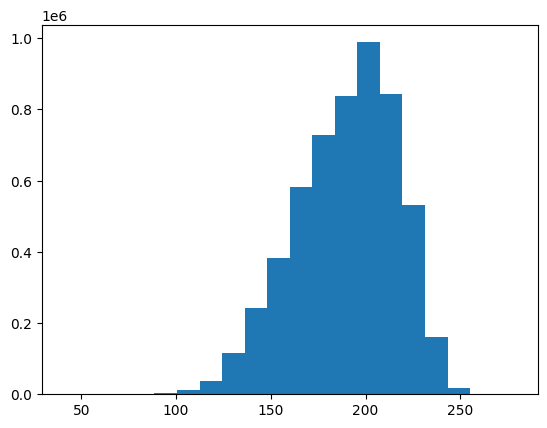

In [32]:
plt.hist([len(tok) for tok in tokens], bins=20)
plt.show()

In [33]:
tok_len = np.array([len(tok) for tok in tokens])
np.mean(tok_len > 256)

0.0003067278250097699

### Dataset creation

In [9]:
indices = np.arange(len(tokens) // init_repeat)
np.random.shuffle(indices)

pickle.dump(indices, open('augapply-test-split', 'wb'))

In [2]:
import pickle

tokens = pickle.load(open('augapply-tokens', 'rb'))

In [3]:
indices = pickle.load(open('augapply-test-split', 'rb'))
indices

array([371011, 104986, 228788, ..., 171617, 402401, 403608])

In [4]:
from datasets import Dataset, DatasetDict

max_tokens = 256
test_size = 0.05
init_repeat = 10
repeat = 3

split = int(len(indices) * test_size)
test_indices, train_indices = indices[:split], indices[split:]
test_tok = [tokens[init_repeat * j] for j in test_indices]
train_tok = [tokens[init_repeat * j + i] for i in range(repeat) for j in train_indices]
test_data = Dataset.from_dict({'input_ids': [tok for tok in test_tok if len(tok) <= max_tokens]})
train_data = Dataset.from_dict({'input_ids': [tok for tok in train_tok if len(tok) <= max_tokens]})

dataset = DatasetDict({'train': train_data, 'test': test_data})

In [5]:
from transformers import GPT2Config, GPT2LMHeadModel

config = GPT2Config(vocab_size=len(tokenizer), n_positions=max_tokens, n_embd=128, n_layer=8, n_head=8, 
                    bos_token_id=tokenizer.eos_token_id, eos_token_id=tokenizer.eos_token_id)
model = GPT2LMHeadModel(config)
print('Total parameters {0}'.format(sum(p.numel() for p in model.parameters())))

Total parameters 1644928


In [9]:
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

epoch_num = 2
batch_size = 64
max_steps = (epoch_num * len(train_tok)) // batch_size

collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False, pad_to_multiple_of=8)

training_args = TrainingArguments(
    output_dir="./augapply-output-repeat-3-rightpad",
    max_steps=max_steps,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=64,
    eval_strategy="steps",
    save_steps=10000,
    eval_steps=10000,
    learning_rate=5e-4,
    weight_decay=0.01,
    lr_scheduler_type='cosine',
    warmup_steps=3000,
    logging_dir='./augapply-logs',
    report_to='none'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=collator,
)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
max_steps is given, it will override any value given in num_train_epochs


In [10]:
trainer.train()

Step,Training Loss,Validation Loss
10000,0.369800,0.348954
20000,0.346600,0.336698
30000,0.337700,0.330884
40000,0.333300,0.326895


TrainOutput(global_step=48839, training_loss=0.37797720019922165, metrics={'train_runtime': 4413.9101, 'train_samples_per_second': 708.147, 'train_steps_per_second': 11.065, 'total_flos': 7196205717307392.0, 'train_loss': 0.37797720019922165, 'epoch': 2.000614451908897})

In [15]:
trainer.save_model('augapply-output-repeat-3-rightpad/checkpoint-48839')

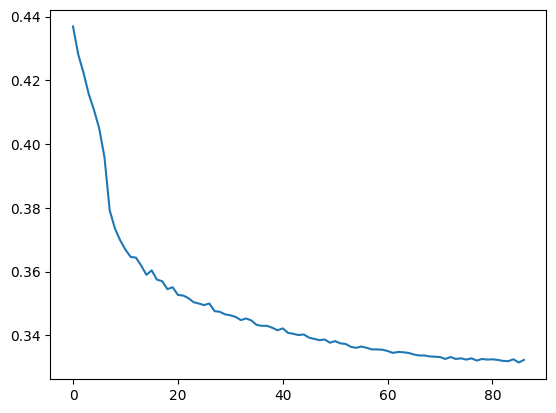

In [14]:
plt.plot([x['loss'] for x in trainer.state.log_history if 'loss' in x][10:])
plt.show()

In [17]:
from transformers import GPT2Config, GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained('augapply-output-repeat-3-rightpad/checkpoint-48839').cuda()
_ = model.eval()

In [18]:
import torch
from transformers import StoppingCriteria, StoppingCriteriaList

class StoppingCriteriaQed(StoppingCriteria):
    def __init__(self, stops = torch.tensor(tokenizer.encode('Qed.'), device='cuda'), encounters=1):
        super().__init__()
        self.stops = stops
        self.encounters = encounters

    def __call__(self, input_ids, scores):
        stop_count = torch.all(input_ids[0].unfold(0, len(self.stops), 1) == self.stops, 1).sum().item()
        return stop_count >= self.encounters

In [20]:
def pretty(string):
    return ''.join(string.split('##'))

def get_premise(theorem):
    return theorem.split('.')[0] + '.'

def generate(tokens):
    theorems = [pretty(s) for s in tokenizer.batch_decode(tokens, skip_special_token=True)]
    premises = [get_premise(theorem) for theorem in theorems]
    model_inputs = tokenizer(premises, return_tensors='pt', padding=True).to('cuda')    
    generated_ids = model.generate(**model_inputs, pad_token_id=tokenizer.eos_token_id, 
                                   max_length=max_tokens, num_beams=10, do_sample=True,
                                   stopping_criteria=StoppingCriteriaList([StoppingCriteriaQed()]))
    return [pretty(s) for s in tokenizer.batch_decode(generated_ids, skip_special_tokens=True)]

def normalize_proof(proof):
    norm = proof.split('Qed.')[0]
    if norm[-1] != '\n':
        norm += '\n'
    norm += 'Qed.'
    return norm

In [23]:
len(test_data)

27412

In [22]:
from tqdm import tqdm

batch_size = 128
data = test_data['input_ids'] 
#data = train_data['input_ids'][:12800*repeat:repeat]

with open('augtest-repeat-3-rightpad.v', 'w') as f:
    for i in tqdm(range(0, len(data), batch_size)):
        proofs = generate(data[i: i + batch_size])
        for proof in proofs:
            print(normalize_proof(proof), file=f, flush=True)

100%|██████████| 215/215 [1:12:16<00:00, 20.17s/it]


In [15]:
1

1

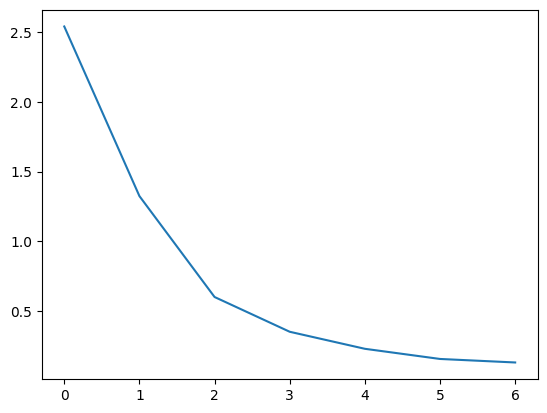

In [52]:
size = np.array([1, 2, 5, 10, 20, 50, 100])
time = np.array([2.54, 2.65, 3.01, 3.53, 4.62, 7.91, 13.3])

plt.plot(time / size)
plt.show()

In [107]:
torch.cuda.empty_cache()
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Tue Jan 23 21:47:19 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100S-PCI...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   36C    P0    50W / 250W |  15344MiB / 32768MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100S-PCI...  Off  | 00000000:AF:00.0 Off |                    0 |
| N/A   

In [100]:
model_inputs = tokenizer("Theorem weygig: forall (Z B E Q N : Prop), ((B -> Z) -> Z) -> (Z -> B) -> (B -> Q -> E) -> (Z -> Q) -> (B -> Q) -> (B -> N) -> (B -> N -> Q -> E) -> (E -> Z) -> E.", return_tensors="pt").to("cuda")
generated_ids = model.generate(**model_inputs, pad_token_id=tokenizer.eos_token_id, max_length=256, num_beams=10, 
                               do_sample=True, stopping_criteria=StoppingCriteriaList([StoppingCriteriaQed()]))
print(''.join(tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0].split('##')))

Theorem weygig: forall (Z B E Q N : Prop), ((B -> Z) -> Z) -> (Z -> B) -> (B -> Q -> E) -> (Z -> Q) -> (B -> Q) -> (B -> N) -> (B -> N -> Q -> E) -> (E -> Z) -> E.
Proof.
intros Z B E Q N. intros HBZZ HZB HBQE HZQ HBQ HBN HBNQE HEZ. apply HBQE. 
  - apply HZB. apply HBZZ. intros HB. apply HEZ. apply HBQE. 
    + apply HB. 
    + apply HBQ. apply HB. 
  - apply HZQ. apply HBZZ. intros HB0. apply HEZ. apply HBQE. 
    + apply HB0. 
    + apply HBQ. apply HB0. 
Qed.


In [35]:
len(tokenizer)

201

train / val loss

8 layer - 8 head - 256 emb - 6.5M - 0.2116 - 0.2092